In [1]:
import sys
sys.path.append('..')

from torchvision import datasets
import torch
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch import cat, Generator
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

from semantic_segmentation_voc.transforms import pair_transforms_train, pair_transforms_val
from semantic_segmentation_voc.utils import display_images
from semantic_segmentation_voc.model import CustomCNNEncoderDecoder
from semantic_segmentation_voc.train import train 

/home/tgniazdo/semantic segmentation VOC/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_ds = datasets.VOCSegmentation("data", 
                                    year="2012", 
                                    image_set="train", 
                                    transforms=pair_transforms_train, 
                                    download=False)
val_test_ds = datasets.VOCSegmentation("data", 
                                       year="2012", 
                                       image_set="val", 
                                       transforms=pair_transforms_val, 
                                       download=False)
val_ds, _ = random_split(val_test_ds, [0.5, 0.5], generator=Generator().manual_seed(42))

In [3]:
len(train_ds), len(val_ds)

(1464, 725)

100%|██████████| 5/5 [00:00<00:00, 4915.97it/s]


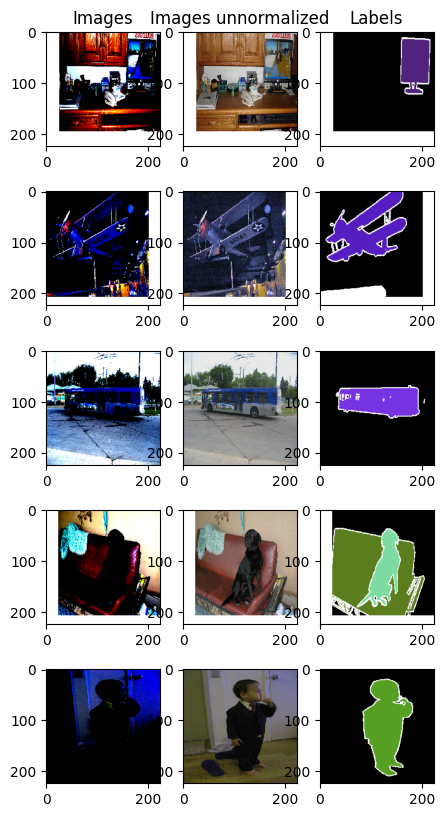

In [4]:
display_images(
    dataset=train_ds,
    rows=5,
    size=10
    )

100%|██████████| 5/5 [00:00<00:00, 4983.73it/s]

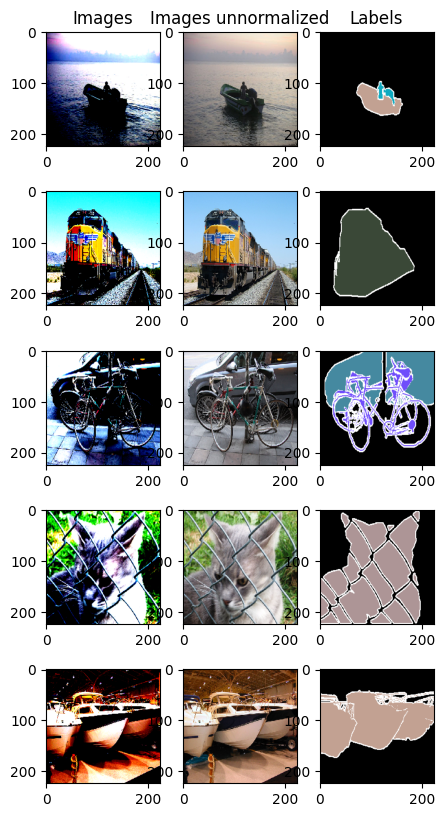

In [5]:
display_images(dataset=val_ds,
               rows=5,
               size=10)

In [6]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

In [7]:
all_pixels_values = cat([y.flatten() for _, y in train_ds], dim=0)

In [8]:
class_weights = compute_class_weight("balanced",
                                     classes=list(range(21)) + [255], 
                                     y=all_pixels_values.tolist())[:-1] # without the ignore index (255)

Text(0.5, 1.0, 'Class weights')

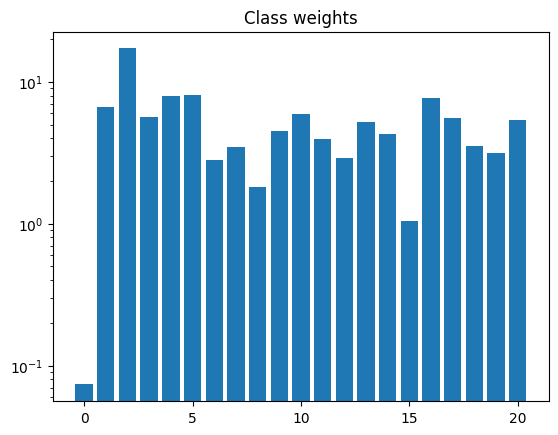

In [9]:
plt.bar(range(len(class_weights)), class_weights)
plt.yscale("log")
plt.title("Class weights")

100%|██████████| 300/300 [1:48:22<00:00, 21.67s/it, Epoch=299, train loss=0.025, train acc=0.951, val loss=1.74, val acc=0.872]


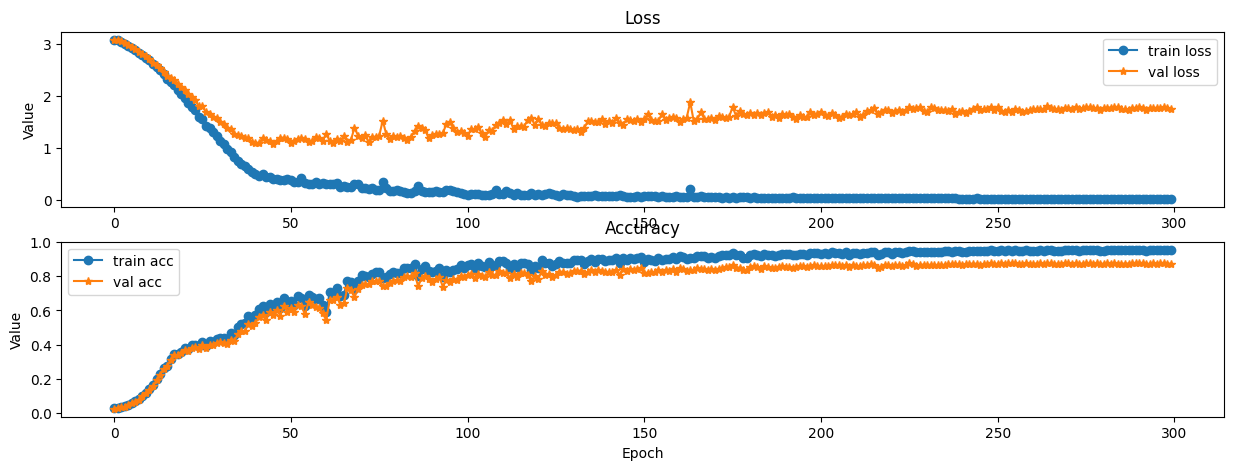

In [10]:
MAX_LR = 1e-4
EPOCHS = 300
PATIENCE = 30
L1_REG_COEF = 1e-6

custom_cnn_encoder_decoder = CustomCNNEncoderDecoder(num_classes=21).to("cuda")
optimizer = Adam(custom_cnn_encoder_decoder.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr=MAX_LR, steps_per_epoch=len(train_dl), epochs=EPOCHS)
loss = CrossEntropyLoss(ignore_index=255, weight=torch.Tensor(class_weights).to("cuda"))

train(
    model=custom_cnn_encoder_decoder, 
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss,
    train_dl=train_dl, 
    val_dl=val_dl, 
    epochs=EPOCHS,
    patience=PATIENCE,
    l1_reg_coef=L1_REG_COEF,
    best_model_path="model/best_model.pth",
    device="cuda",
    print_metrics=True
    )